In [11]:
import re
import nltk
from nltk import word_tokenize,WordNetLemmatizer
nltk.download('stopwords', 'punkt', 'wordnet', 'omw-1.4')
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, LSTM, Dense
from keras import Input, Model
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lemur\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## FONCTIONS ANNEXES

In [44]:
def preprocess(text):
    # Removing HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Removing punctuation and non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z0-9]", " ",  str(text))

    # Tokenizing words
    words = word_tokenize(str(text))

    # Removing stopwords
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if w.lower() not in stop_words]

    # Lemmatizing words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

def filter_words(tokenizer, min_occurrence):
    word_counts = tokenizer.word_counts
    filtered_words = [word for word in word_counts if word_counts[word] >= min_occurrence]
    return filtered_words

## ANALYSE DES DONNEES

In [13]:
pd.set_option('float_format', '{:f}'.format)
answers_df = pd.read_csv("data/Answers.csv", encoding='latin-1')
questions_df = pd.read_csv("data/Questions.csv", encoding='latin-1')
tags_df = pd.read_csv("data/Tags.csv", encoding='latin-1')

In [14]:
# Remove all questions that have a negative score
questions_df = questions_df[questions_df['Score'] >= 0]
questions_df['Text'] = questions_df['Title']+questions_df['Body']
questions_df = questions_df.drop(['Title','Body','CreationDate','OwnerUserId'],axis=1)

In [15]:
questions_df

,Id,Score,Text
0,469,21,How can I find the full path to a font from it...
1,502,27,Get a preview JPEG of a PDF on Windows?<p>I ha...
2,535,40,Continuous Integration System for a Python Cod...
3,594,25,cx_Oracle: How do I iterate over a result set?...
4,683,28,Using 'in' to match an attribute of Python obj...
...,...,...,...
607277,40143190,1,How to execute multiline python code from a ba...
607278,40143228,0,How to get google reCaptcha image source using...
607279,40143267,0,Updating an ManyToMany field with Django rest<...
607280,40143338,2,"Most possible pairs<p>Given a list of values, ..."


In [16]:
answers_df = answers_df.drop(['Id','OwnerUserId','CreationDate'],axis=1)
answers_df.rename(columns={'ParentId':'Id'},inplace=True)
out = questions_df.merge(answers_df,on='Id')

In [17]:
out

,Id,Score_x,Text,Score_y,Body
0,469,21,How can I find the full path to a font from it...,4,<p>open up a terminal (Applications-&gt;Utilit...
1,469,21,How can I find the full path to a font from it...,2,<p>I haven't been able to find anything that d...
2,469,21,How can I find the full path to a font from it...,12,<p>Unfortunately the only API that isn't depre...
3,469,21,How can I find the full path to a font from it...,1,<p>There must be a method in Cocoa to get a li...
4,502,27,Get a preview JPEG of a PDF on Windows?<p>I ha...,9,<p>You can use ImageMagick's convert utility f...
...,...,...,...,...,...
927225,40142906,2,can't assign to function call Error-Python<p>S...,0,<p>I am fairly certain your problem is your us...
927226,40143133,1,error handling with BeautifulSoup when scraped...,1,<p>You may check the value of <code>name_box</...
927227,40143166,1,finding cubed root using delta and epsilon in ...,2,"<p>First thing, you should use <code>if/elif</..."
927228,40143190,1,How to execute multiline python code from a ba...,5,<p>Use a here-doc:</p>\n\n<pre><code>result=$(...


In [18]:
out = out.loc[out.groupby('Id')['Score_y'].idxmax()]

<AxesSubplot:>

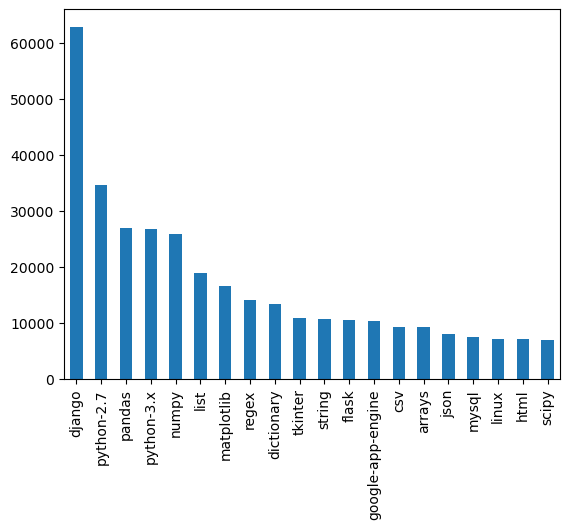

In [19]:
#most frequent tags
fig, ax = plt.subplots()
tags_df[tags_df['Tag']!='python']['Tag'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')

## NETTOYAGE


In [20]:
out['Text'].apply(lambda x:preprocess(x))

C:\Users\lemur\miniconda3\envs\redstring\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


2         find full path font display name Mac using Pho...
6         Get preview JPEG PDF Windows cross platform Py...
7         Continuous Integration System Python CodebaseI...
14        cx Oracle iterate result set several way itera...
23        Using match attribute Python object arrayI rem...
                                ...                        
927223    Different result String Integers using JSON py...
927224    assign function call Error PythonSo working pr...
927226    error handling BeautifulSoup scraped url respo...
927227    finding cubed root using delta epsilon PythonI...
927228    execute multiline python code bash script need...
Name: Text, Length: 503729, dtype: object

In [22]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(out['Text'])

# Keep only the words that occur more than 5 times in the text
filtered_words = filter_words(tokenizer, 5)

# Update the word_index with the filtered words
tokenizer.word_index = {word: i + 1 for i, word in enumerate(filtered_words)}

In [23]:
len(tokenizer.word_index)

246532

In [24]:
questions_seq = tokenizer.texts_to_sequences(out['Text'])
answers_seq = tokenizer.texts_to_sequences(out['Body'])

In [25]:
max_length = 500

In [90]:
# Truncate the sequences if they exceed the maximum length
questions_padded = pad_sequences(questions_seq, maxlen=max_length, truncating='post')
answers_padded = pad_sequences(answers_seq, maxlen=max_length, truncating='post')

In [93]:
# Splitting the data into train, validation, and test sets
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(questions_seq, answers_seq, test_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

In [94]:
len(tokenizer.word_index)

246532

## MODEL & TRAINNING

In [95]:
# Build the seq2seq model
encoder_inputs = Input(shape=(max_length,))
encoder_embedding = Embedding(len(tokenizer.word_index) + 1, 128)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_length,))
decoder_embedding = Embedding(len(tokenizer.word_index) + 1, 128)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy")

In [96]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 500)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 500, 128)     31556224    ['input_9[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 500, 128)     31556224    ['input_10[0][0]']               
                                                                                            

In [ ]:
max_length = 500
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

y_train = pad_sequences(y_train, maxlen=max_length, truncating='post')
y_val_ = pad_sequences(y_val, maxlen=max_length, truncating='post')



In [110]:
X_train.shape

(100745, 500)

In [111]:
y_train.shape

(100745, 500)

In [113]:
# Fit the model
model.fit([X_train, y_train], y_train, validation_data=([X_val, y_val], y_val), batch_size=16, epochs=10)

Epoch 1/10
  12/6297 [..............................] - ETA: 53:43:25 - loss: 12.0900

KeyboardInterrupt: 

In [ ]:
# Save the trained model
model.save('myChatbot.h5')